In [1]:
%matplotlib notebook

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import deterministic_models as dm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
import theano_optimization as opt
from schlichtanders.myoptimizers import batch
import probabilistic_models as pm
import time

gnumpy: failed to import cudamat. Using npmat instead. No GPU will be used.


# Deterministic Model - one dimensional

## model

In [ ]:
model = dm.RadialTransform(size=1)
f_model = model.function()

## target

In [ ]:
target = dm.RadialTransform(init_alpha=1, init_beta=20, init_z0=[3])

In [ ]:
f_target = target.function()
f_target([7])  # caution, needs vector not scalar input

In [ ]:
N = 40
xs = np.linspace(-10, 10, N)[:, np.newaxis]
xs[:7]

In [ ]:
ys = np.array([f_target(x) for x in xs])
ys[:7]

## visualization

In [ ]:
def plot_fit(fig, ax, time_delay=0.1):
    ax.clear() # interactive
    # target data:
    ax.plot(xs, ys, 'k:')
    
    # model:
    model_ys = np.array([f_model(x) for x in xs])
    ax.plot(xs, model_ys, 'r')
    
    fig.canvas.draw()
    time.sleep(time_delay)

In [ ]:
fig, ax = plt.subplots()
plot_fit(fig, ax)

## fit

In [ ]:
myoptimizer = opt.ScipyOptimizer(batch)
# CAUTION: scipy args needs to be tuple in order to work as expected!
myoptimizer.optimize(
    model, args=(ys,xs),
    # method="Newton-CG",
    options={'maxiter':100, 'disp':True},
    callback=lambda x: plot_fit(fig, ax)
)

# two dimensions

## model

In [ ]:
model2d = dm.RadialTransform(size=2)
f_model2d = model2d.function()

## target

In [ ]:
target2d = dm.RadialTransform(init_alpha=1, init_beta=5, init_z0=[3, 1])
# target2d = dm.RadialTransform(init_alpha=50, init_beta=-40, init_z0=[3, 1])

In [ ]:
f_target2d = target2d.function()
f_target2d([7, 4])  # caution, needs vector not scalar input

In [ ]:
N2d = 10
_xs = np.linspace(-10, 10, N2d)
X1, X2 = np.meshgrid(_xs, _xs)
xs2d = np.c_[X1.flat, X2.flat]
xs2d[:5]

In [ ]:
ys2d = np.array([f_target2d(x) for x in xs2d])
ys2d[:5]

## visualization

In [ ]:
diff2d = ys2d - xs2d
quiver_kwargs = dict(scale=1, angles='xy', scale_units='xy', width=0.003)

def plot_fit2d(fig, ax, time_delay=0.1, expand_factor=0.4):
    ax.clear()
    
    # target data:
    ax.quiver(xs2d[:,0], xs2d[:,1], diff2d[:,0], diff2d[:,1], hatch='***', facecolor='none', color="k", **quiver_kwargs)
    
    # model:
    m_ys2d = np.array([f_model2d(x) for x in xs2d])
    m_diff2d = m_ys2d - xs2d
    ax.quiver(xs2d[:,0], xs2d[:,1], m_diff2d[:,0], m_diff2d[:,1], color="r", **quiver_kwargs)

    # ax.autoscale()  # does not work with arrows, do it manually:
    l, r, b, t = ax.axis()
    dx, dy = r - l, t - b
    ax.axis([l - expand_factor * dx, r + expand_factor * dx, b - expand_factor * dy, t + expand_factor * dy])
    
    fig.canvas.draw()
    time.sleep(time_delay)

In [ ]:
fig, ax = plt.subplots()
plot_fit2d(fig, ax)

## fit

In [ ]:
myoptimizer = opt.ScipyOptimizer(batch)
# CAUTION: scipy args needs to be tuple in order to work as expected!
myoptimizer.optimize(
    model2d, args=(ys2d,xs2d),
#     method="Newton-CG",
    options={'maxiter':100, 'disp':True},
    callback=lambda x: plot_fit2d(fig, ax)
)

# Probabilistic Normalizing Flow

Only the combination with gaussian base function is shown. The uniform base function has the disadvantage of not being differentiable (not yet supported).

## model

In [11]:
size=2
base_model = pm.DiagGauss(size)
# CAUTION, this transform cannot be reused elsewhere, as it is merged into normalizing flow
# its references point always to the current substitution
transform_model = dm.RadialTransform(size, init_alpha=2)

In [12]:
model = pm.NormalizingFlow(transform_model, base_model)
m_sampler = model.function()
m_sampler()

array([-1.35920258, -1.02165152])

## target

In [5]:
base_target = pm.DiagGauss(init_mean=[5,5], init_var=(10,5))
transform_target = dm.RadialTransform(init_z0=[5,5], init_beta=30, init_alpha=3)

In [6]:
target = pm.NormalizingFlow(transform_target, base_target)
t_sampler = target.function()
t_sampler()

array([ -7.63032495,  10.59767905])

In [7]:
n_samples = 2000
targets = np.array([t_sampler() for _ in xrange(n_samples)])

## visualization

In [8]:
scatter_kwargs = dict(edgecolors="face", alpha=0.01, s=5000)
outer = dict(i=0)
def plot_fit(fig, ax, time_delay=0.1):
    outer['i'] += 1
    ax.clear()
    
    # targets
    ax.plot(targets[:,0], targets[:,1], 'k.')
#     ax.scatter(targets[:,0], targets[:,1], c='k', **scatter_kwargs)
    # model
    m_samples = np.array([m_sampler() for _ in xrange(n_samples)])
    ax.scatter(m_samples[:,0], m_samples[:,1], c='r',**scatter_kwargs)

    fig.canvas.draw()
    if time_delay is not None:
        time.sleep(time_delay)

<IPython.core.display.Javascript object>


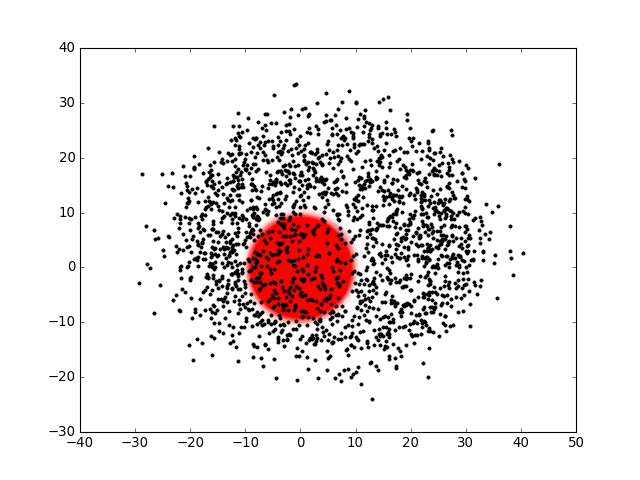

In [9]:
fig, ax = plt.subplots()
plot_fit(fig, ax)

## fit

In [14]:
myoptimizer = opt.ScipyOptimizer(batch)
# CAUTION: scipy args needs to be tuple in order to work as expected!
myoptimizer.optimize(
    model, args=(targets,),
#     method='CG',
#     method="Newton-CG",
#     method="Nelder-Mead",
    options={'maxiter':10000, 'disp':True},
    callback=lambda x: plot_fit(fig, ax, time_delay=0.001)
)

Optimization terminated successfully.
         Current function value: 101651.731484
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1


      fun: array(101651.73148390374)
 hess_inv: array([[1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1]])
      jac: array([ 135.53565289,  227.02094122,           nan,           nan,
                 nan,           nan,           nan,           nan])
  message: 'Optimization terminated successfully.'
     nfev: 1
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([  4.15294197e+02,   4.38364603e+02,   6.07242075e+03,
         3.84652382e+03,  -1.16917224e+03,   1.23896972e+03,
        -7.77704907e-01,  -1.35719191e+00])

In [17]:
alpha = transform_model.alpha_from_Alpha(transform_model._Alpha.get_value(), module=np)
beta = transform_model.beta_from_Beta(alpha, transform_model._Beta.get_value(), module=np)
print alpha, beta

0.0 inf
